In [11]:
#Import Packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import matplotlib
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import sys
sys.path.append('..')
import funcs.ac_funcs as ac
sys.path.append('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1')
from atmos.utils import met_utils, datetime_utils
pd.options.mode.chained_assignment = None

In [16]:
#Declare functions
def plot_reg_on_ax(ax,reg_details,labsize = 10,color = 'grey',slope_permil=False,yint_permil = False):
    '''Plots a regression line and its details on a matplotlib ax and legend
    
    Args:
    ax (axis from plt): a plt ax object on which to plot
    reg_details (dict) : details of the regression, generated by lin_regress_2()
    labsize (int) : size of the label for the legend
    
    Returns:
    ax : plt ax object with the regression line and legend plotted
    '''
    r2_val = reg_details['r2']
    if slope_permil:
        slope_val = reg_details['slope']*1000 #get the "per mille" value by multiplying by 1000
    else:
        slope_val = reg_details['slope']
    if yint_permil:
        yint_val = reg_details['yint']*1000
    else:
        yint_val = reg_details['yint']
                               
    annotation = f"R2={r2_val:.2}\n"
    annotation += f"slope={slope_val:.5}"
    if slope_permil:
        annotation +=  "$^o/_{oo}$"
    annotation += '\n'
    annotation += f"y_int={yint_val:.3}"
    if yint_permil:
        annotation +=  "$^o/_{oo}$"

    ax.plot(reg_details['x_regr_line'],reg_details['y_regr_line'],label = annotation,c = color)
    leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True,fontsize = labsize)
    for item in leg.legend_handles:
        item.set_visible(False)
    return ax

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [3]:
em27_data_dir = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof'

In [4]:
#Define parameters
inst_ids = ['ha','ua']
resample = '5min'
timezone = 'US/Mountain' 
specs = ['xch4(ppm)','xco2(ppm)','xco(ppb)']

In [5]:
#Define and create dataframe for the periods where EM27s were side by side, to get correction

#These are the periods when the two em27's were side by side. 
dt_str_ranges = [{'start':'2024-07-20 00:00:00','end':'2024-07-25 23:59:59'},
                 {'start':'2024-09-01 00:00:00','end':'2024-09-07 23:59:59'}]
my_oof_managers = {} #initialize the oof managers dictionary
sbs_oof_dfs = {} #initialize the oof dataframe dictionary
for inst_id in inst_ids: #loop through the instruments
    sbs_oof_dfs[inst_id] = pd.DataFrame() #initialize the instrument's dataframe
    for dt_str_range in dt_str_ranges: #loop through the datetime ranges to append the correct subset of values
        dt1 = ac.dtstr_to_dttz(dt_str_range['start'],timezone) #set the start datetime
        dt2 = ac.dtstr_to_dttz(dt_str_range['end'],timezone) #set the end datetime
        data_folder = os.path.join(em27_data_dir,inst_id) #set the data folder for that instrument
        my_oof_managers[inst_id] = ac.oof_manager(data_folder,timezone) #create the oof manager class to load
        df = my_oof_managers[inst_id].load_oof_df_inrange(dt1,dt2,filter_flag_0=False,cols_to_load = specs) #load the dataframe in the range, filter on good values
        df = df.loc[(df['flag'] == 0) | (df['flag'] == 23)]
        if resample is not None: #if we want to resample
            df = df.resample(resample).mean(numeric_only = True) #do so
        sbs_oof_dfs[inst_id] = pd.concat([sbs_oof_dfs[inst_id],df]) #add the rows to the instrument's oof df
merged_df = ac.merge_oofdfs(sbs_oof_dfs,dropna=True) #merge the oof dfs and drop na values (not needed in regression)

# Do regressions for each species to use to correct instruments that were side by side
sbs_regressions = {}
for spec in specs:
    x_spec = f'{spec}_ua'
    y_spec = f'{spec}_ha'
    regression = ac.lin_regress_2(merged_df,x_spec,y_spec)
    sbs_regressions[spec] = regression

# Correct ua data to ha data using the regressions
for spec in specs:
    merged_df[f'corr_{spec}_ha'] = merged_df[f'{spec}_ha']
    merged_df[f'corr_{spec}_ua'] = merged_df.apply(lambda row: row[f'{spec}_ua']*sbs_regressions[spec]['slope']+sbs_regressions[spec]['yint'] ,axis = 1)

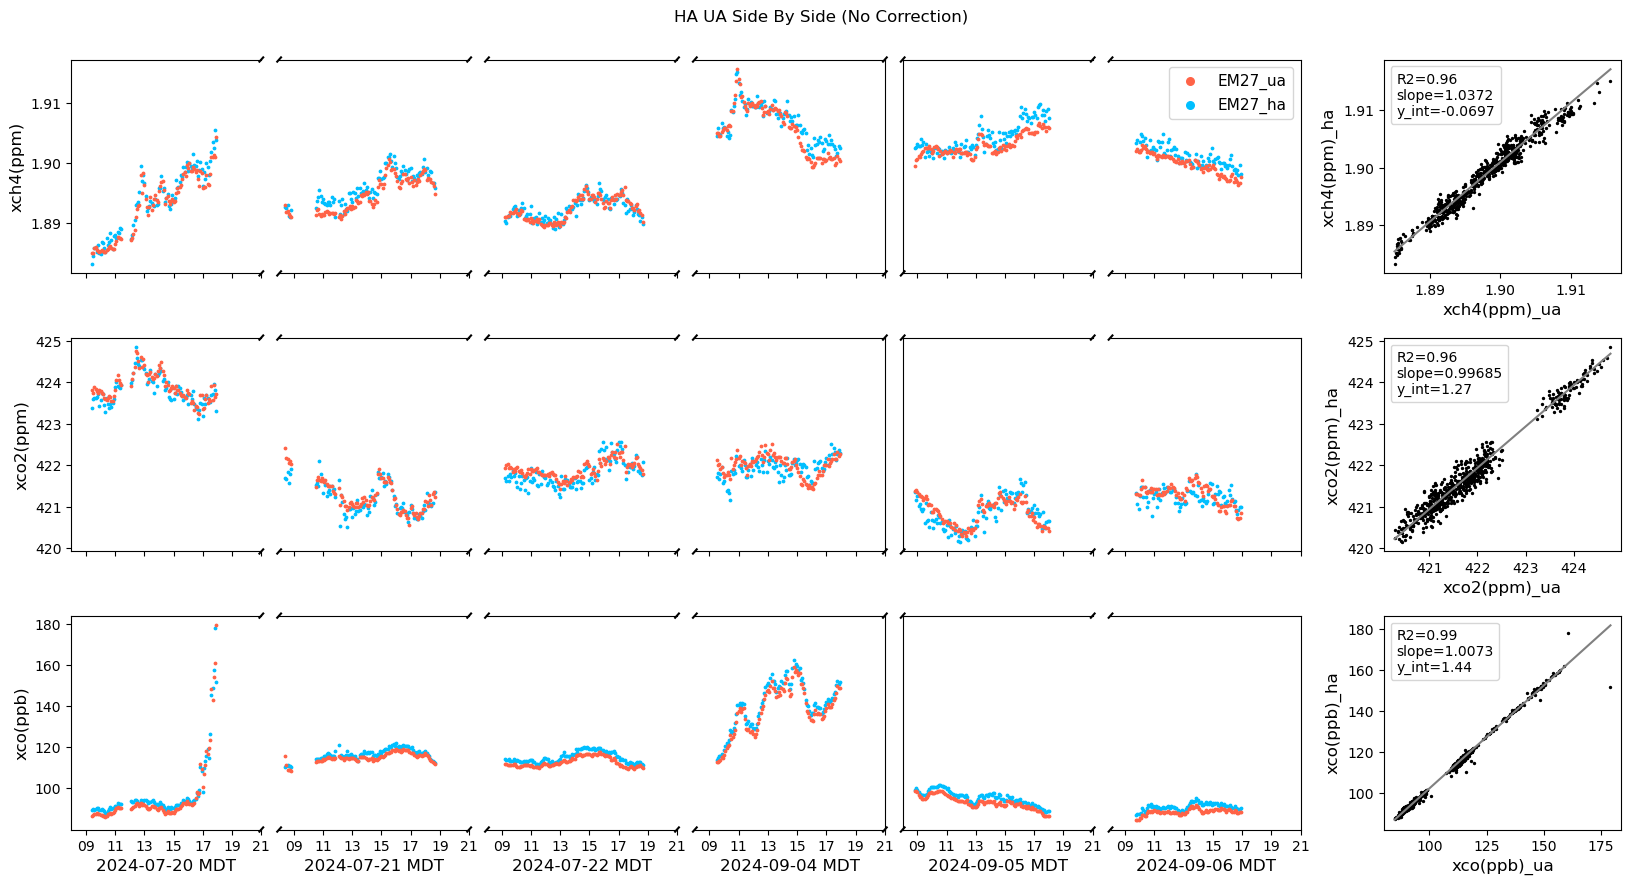

In [6]:
#Plot side by side data before the correcion, with the regression subplots to the right. 

dates = sorted(list(set(merged_df.index.date)))
broken_dtranges = []
for date in dates:
    dtstart_str = f'{date} 08:00:00'
    dtend_str = f'{date} 21:00:00'
    broken_dtranges.append([pd.to_datetime(dtstart_str).tz_localize('US/Mountain'),pd.to_datetime(dtend_str).tz_localize('US/Mountain')])

fig = plt.figure(figsize = (20,10))
gs = gridspec.GridSpec(len(specs),8,width_ratios=[.8,.8,.8,.8,.8,.8,.2,1])
ua_color = 'tomato'
ha_color = 'deepskyblue'
em27_marker_size = 3
gridalpha = 0.2
labelsize = 12
d = .01 # how big to make the diagonal lines in axes coordinates
for row in range(len(specs)):
    spec = specs[row]
    for col in range(len(broken_dtranges)):
        ax = plt.subplot(gs[row,col])
        ax.scatter(merged_df.index,merged_df[f'{spec}_ha'],color =ha_color,s = em27_marker_size)
        ax.scatter(merged_df.index,merged_df[f'{spec}_ua'],color =ua_color,s = em27_marker_size)
        if col == 0:
            alpha = 0.8
        else:
            alpha = 1
        ax.set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
        if col<len(broken_dtranges)-1:
            if col != 3:
                ax.spines['right'].set_visible(False)
            ax.yaxis.tick_left()
        if col > 0:
            ax.yaxis.set_visible(False)
        if col>0:
            if col !=4:
                ax.spines['left'].set_visible(False)
            ax.yaxis.tick_right()
        if col<len(broken_dtranges)-1:
            kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
            ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
            ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
        if col>0:
            kwargs.update(transform=ax.transAxes) # switch to the bottom axes
            ax.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
            ax.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
        ax.get_xaxis().set_ticklabels([])
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.set_ylabel(spec,size = labelsize)
        ax.tick_params(labelsize = labelsize-2)
        if (row == 0)&(col==5):
            ax.scatter([],[],color = ua_color,s = 30,label='EM27_ua')
            ax.scatter([],[],color = ha_color,s = 30,label='EM27_ha')
            ax.legend(fontsize = labelsize-1)
        if row == 2:  
            ax.tick_params(labelsize = labelsize-2)
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))   
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H',tz='US/Mountain'))
            ax.set_xlabel(f"{broken_dtranges[col][0].strftime('%Y-%m-%d')} MDT",size =labelsize)     
    ax = plt.subplot(gs[row,len(broken_dtranges)])
    ax.set_visible(False)
    ax = plt.subplot(gs[row,len(broken_dtranges)+1])
    x = f'{spec}_ua'
    y = f'{spec}_ha'
    ax.scatter(merged_df[x],merged_df[y],color = 'k',s=2)
    plot_reg_on_ax(ax,sbs_regressions[spec])
    ax.set_xlabel(x,size = labelsize)
    ax.set_ylabel(y,size = labelsize)
    ax.tick_params(labelsize = labelsize-2)
plt.subplots_adjust(hspace=0.3,wspace = 0.1)
fig.suptitle('HA UA Side By Side (No Correction)',y=.93)
#fig.savefig(os.path.join(figures_dir,'sbs_uncorrected.png'),dpi=1000)
fig.show()

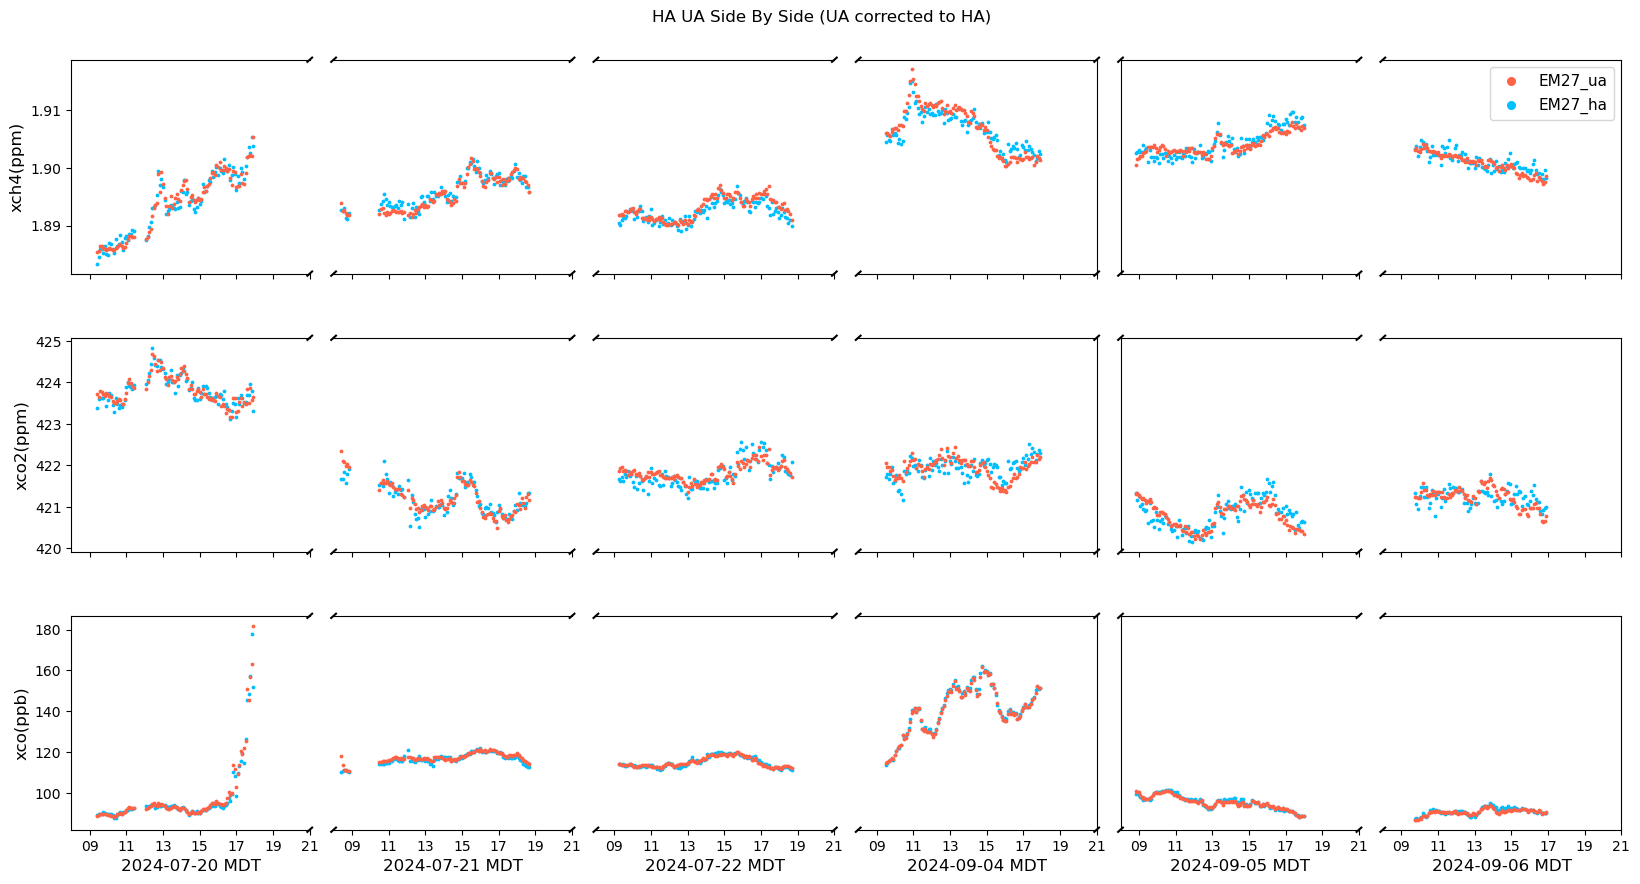

In [7]:
#Plot side by side data after the corrections to show matching

show = False
fig = plt.figure(figsize = (20,10))
gs = gridspec.GridSpec(3,6)
ua_color = 'tomato'
ha_color = 'deepskyblue'
em27_marker_size = 3
gridalpha = 0.2
labelsize = 12
d = .01 # how big to make the diagonal lines in axes coordinates
for row in range(len(specs)):
    spec = specs[row]
    for col in range(len(broken_dtranges)):
        ax = plt.subplot(gs[row,col])
        ax.scatter(merged_df.index,merged_df[f'corr_{spec}_ha'],color =ha_color,s = em27_marker_size)
        ax.scatter(merged_df.index,merged_df[f'corr_{spec}_ua'],color =ua_color,s = em27_marker_size)
        if col == 0:
            alpha = 0.8
        else:
            alpha = 1
        ax.set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
        if col<len(broken_dtranges)-1:
            if col != 3:
                ax.spines['right'].set_visible(False)
            ax.yaxis.tick_left()
        if col > 0:
            ax.yaxis.set_visible(False)
        if col>0:
            if col !=4:
                ax.spines['left'].set_visible(False)
            ax.yaxis.tick_right()
        if col<len(broken_dtranges)-1:
            kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
            ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
            ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
        if col>0:
            kwargs.update(transform=ax.transAxes) # switch to the bottom axes
            ax.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
            ax.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
        ax.get_xaxis().set_ticklabels([])
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.set_ylabel(spec,size = labelsize)
        ax.tick_params(labelsize = labelsize-2)
        if (row == 0)&(col==5):
            ax.scatter([],[],color = ua_color,s = 30,label='EM27_ua')
            ax.scatter([],[],color = ha_color,s = 30,label='EM27_ha')
            ax.legend(fontsize = labelsize-1)
        if row == 2:  
            ax.tick_params(labelsize = labelsize-2)
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))   
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H',tz='US/Mountain'))
            ax.set_xlabel(f"{broken_dtranges[col][0].strftime('%Y-%m-%d')} MDT",size =labelsize)     

plt.subplots_adjust(hspace=0.3,wspace = 0.1)
fig.suptitle('HA UA Side By Side (UA corrected to HA)',y=.93)
fig.show()

In [8]:
#Define parameters
inst_ids = ['ha','ua']
resample = '1min'
timezone = 'US/Mountain' 
specs = ['xch4(ppm)','xco2(ppm)','xco(ppb)']

In [19]:
dt1_str = '2024-07-20 00:00:00'
dt2_str = '2024-09-07 23:59:59' 
timezone = 'US/Mountain' 
resample = '1min'
specs = ['xch4(ppm)','xco2(ppm)','xco(ppb)']
keep_cols = ['inst_zasl', 'inst_lat', 'inst_lon','tout(C)','pout(hPa)', 'hout(%RH)',
             'corr_xch4(ppm)','xch4(ppm)_error', 'corr_xco2(ppm)','xco2(ppm)_error','corr_xco(ppb)','xco(ppb)_error',
             'xh2o(ppm)', 'xh2o(ppm)_error','xluft', 'xluft_error']
dt1 = ac.dtstr_to_dttz(dt1_str,timezone)
dt2 = ac.dtstr_to_dttz(dt2_str,timezone)
my_oof_managers = {}
oof_dfs = {}
for inst_id in inst_ids:
    data_folder = os.path.join(em27_data_dir,inst_id)
    my_oof_managers[inst_id] = ac.oof_manager(data_folder,timezone)
    df = my_oof_managers[inst_id].load_oof_df_inrange(dt1,dt2,filter_flag_0=False,print_out=False) #load the dataframe in the range, filter on good values
    df = df.loc[(df['flag'] == 0) | (df['flag'] == 23)]
    for spec in specs:
        if inst_id == 'ua':
            df[f'corr_{spec}'] = df.apply(lambda row: row[spec]*sbs_regressions[spec]['slope']+sbs_regressions[spec]['yint'] ,axis = 1)
        else:
            df[f'corr_{spec}'] = df[spec]
    if resample is not None:
        df = df.resample(resample).mean(numeric_only = True)
    df = df[keep_cols]
    oof_dfs[inst_id] = df.dropna(how='all')

oof_dfs['ha'].insert(0,'inst_loc', 'WBB')

ua_syr_dt1 =  ac.dtstr_to_dttz('2024-07-26 00:00:00','US/Mountain')
ua_syr_dt2 =  ac.dtstr_to_dttz('2024-08-31 00:00:00','US/Mountain')
ua_loc_col = oof_dfs['ua'].apply(lambda row: 'SYR' if (row.name>ua_syr_dt1) & (row.name<ua_syr_dt2) else 'WBB',axis = 1)
oof_dfs['ua'].insert(0,'inst_loc', ua_loc_col)




In [20]:
mh = met_utils.MetHandler()
dtr = datetime_utils.DateTimeRange('2024-07-20 00:00:00','2024-09-10 00:00:00',tz = 'US/Mountain')
met_type = 'ggg'

data_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/EM27/ha/inst_data/met/WBB'
wbb_df = mh.load_stddata_in_range(met_type, data_path, dtr)
wbb_df[['u','v']] = wbb_df.apply(lambda row: ac.wdws_to_uv(row['ws'],row['wd']),axis = 1,result_type='expand') #add wind columns for u and v to do averaging if needed


data_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/EM27/ua/inst_data/met/UUSYR'
syr_df = mh.load_stddata_in_range(met_type, data_path, dtr)
syr_df[['u','v']] = syr_df.apply(lambda row: ac.wdws_to_uv(row['ws'],row['wd']),axis = 1,result_type='expand') #add wind columns for u and v to do averaging if needed


In [22]:
before_hours = 1
after_hours = 1
windmode = 5
plot_vars = ['corr_xch4(ppm)','corr_xco2(ppm)','corr_xco(ppb)']
save_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Figures/summer_2024_em27'

dates_list = sorted(list(set(oof_dfs['ha'].index.date)))
for date in dates_list:
    sub_oof_dfs = {}
    for inst_id in oof_dfs.keys():
        df = oof_dfs[inst_id].copy()
        df = df.loc[df.index.date == date] 
        if len(df) == 0:
            continue
        sub_oof_dfs[inst_id] = df

    wbb_daydf = wbb_df.loc[wbb_df.index.date == date]
    syr_daydf = syr_df.loc[syr_df.index.date == date]


    fig,axes = plt.subplots(len(plot_vars)+1,1,figsize = (15,7.5),height_ratios=[2,2,2,1.5])
    labsize = 14
    markersize = 3
    xlim0_list = []
    xlim1_list = []
    for inst_id in sub_oof_dfs.keys():
        xlim0_list.append(sub_oof_dfs[inst_id].index[0])
        xlim1_list.append(sub_oof_dfs[inst_id].index[-1])
    xlims = [min(xlim0_list)-datetime.timedelta(hours=before_hours),max(xlim1_list)+datetime.timedelta(hours=after_hours)]
    row = 0
    for plot_spec in plot_vars:
        for inst_id in sub_oof_dfs.keys():
            if inst_id == 'ha':
                scatter_color = ha_color
            else:
                scatter_color = ua_color
            plotdf = sub_oof_dfs[inst_id]
            axes[row].scatter(plotdf.index,plotdf[plot_spec],color = scatter_color,zorder=3,label=f'{inst_id} resample {resample}',s=markersize)
            axes[row].errorbar(plotdf.index,plotdf[plot_spec],
                            yerr=plotdf[f"{plot_spec.split('_')[-1]}_error"],ls='none',
                            ecolor='grey',alpha=0.2)
        axes[row].tick_params(labelsize = labsize)
        axes[row].set_ylabel(plot_spec.split('_')[-1],size = labsize)
        axes[row].set_xlim(xlims)
        axes[row].xaxis.grid(True)
        if row == 0:
            axes[row].legend(fontsize = labsize *0.8,loc = 'upper right')
        row+=1
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M %Z', tz = plotdf.index[0].tz))
    axes[-1].set_xlabel(sub_oof_dfs['ha'].index[0].strftime('%b %d, %Y'),size = labsize)
    cmap = matplotlib.colormaps['Blues']
    new_cmap = truncate_colormap(cmap, 0.3, 1)
    axes[3].barbs(wbb_daydf[::windmode].index,-5,wbb_daydf['u'][::windmode],wbb_daydf['v'][::windmode],
                    wbb_daydf['ws'][::windmode],cmap = new_cmap,length =6,barb_increments={'half':3,'full':5,'flag':10})
    cmap = matplotlib.colormaps['Reds']
    new_cmap = truncate_colormap(cmap, 0.3, 1)
    axes[3].barbs(syr_daydf[::windmode].index,5,syr_daydf['u'][::windmode],syr_daydf['v'][::windmode],
                    syr_daydf['ws'][::windmode],cmap = new_cmap,length = 6,barb_increments={'half':3,'full':5,'flag':10})

    axes[3].tick_params(labelsize = labsize)
    axes[3].set_ylabel('wind barbs',size = labsize)
    axes[3].get_yaxis().set_ticklabels([])
    axes[3].set_xlim(xlims)
    axes[3].set_ylim(-11,11)

    plt.subplots_adjust(hspace=0.08)
    plt.gcf().autofmt_xdate()
    fig.savefig(os.path.join(save_path,f'{date.strftime("%Y%m%d")}_ua_ha.png'),dpi=400)
    plt.close()
    